In [1]:
cd ~/PycharmProjects/CleanSpace/momia2/

/Users/jzrolling/PycharmProjects/CleanSpace/momia2


In [4]:
import momia2 as mo
import glob, numpy as np
from matplotlib import pyplot as plt
from skimage.measure import approximate_polygon, regionprops
from skimage.filters import gaussian
from skimage.draw import polygon2mask

In [331]:
m = mo.ImageLoader('/Users/jzrolling/Desktop/Daisy_BODIPY/cDXJ3-3_001_composite.tif')

for i in range(m.n_fields):
    data = m.get_slice_all_channels(position=i)
    p = mo.Patch(data)
    p.pixel_microns=0.11
    p.correct_xy_drift()
    #p.crop_edge()
    p.preprocess_images(mo.utils.dual_bandpass,channels='ref',
                        pixel_microns=p.pixel_microns,
                        min_structure_scale=0.1,
                        max_structure_scale=50)
    p.preprocess_images(mo.utils.normalize_image,channels='ref',mask=1)
    p.preprocess_images(mo.utils.rolling_ball_bg_subtraction,channels='fl')
    p.generate_mask(method=5)
    p.label_mask()
    p.locate_particles()
    p.find_outline(approximate=True,tolerance=0.3,
                   level=0.2,dilation=True,sigma=1)
    """
    p.filter_particles({'area': (10, 500),
                      'aspect_ratio': (0.05, 0.8),
                      'solidity': (0.84, 1),
                      'eccentricity': (0.75, 1),
                       })

    """;
    break

Rendering cell plot(s)...


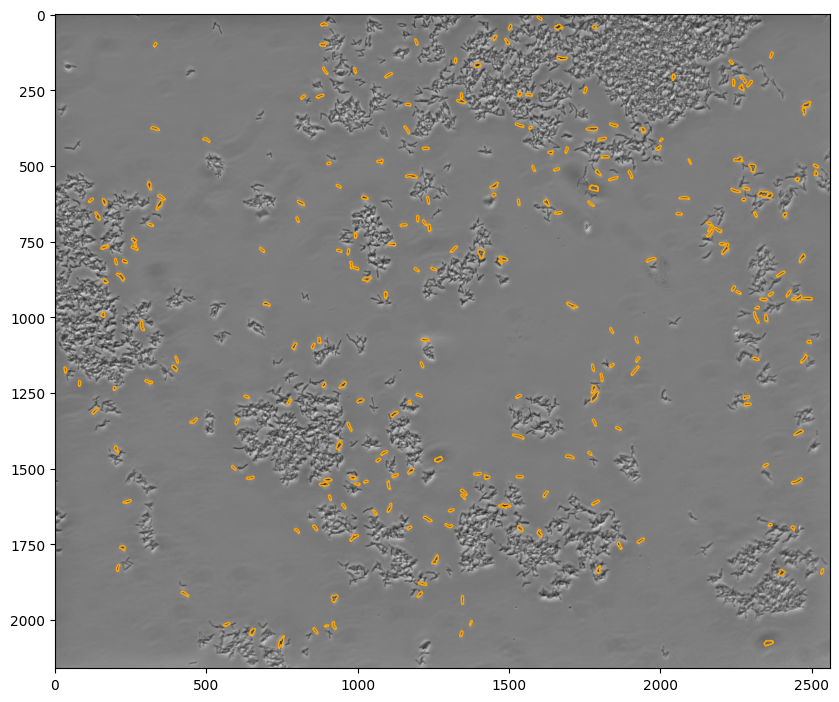

In [334]:
#"""
p.filter_particles({'area': (50, 500),
                  'aspect_ratio': (0.05, 0.8),
                  'solidity': (0.7, 1),
                  'eccentricity': (0.1, 1),
                  'max_positive_curvature':(50,180),
                  'min_negative_curvature': (-10, 50)})
#"""
p.plot(figsize=(10,10))

In [335]:
idx = p.regionprops[p.regionprops['$include']>0].index
part = [p.get_particle_data(x) for x in idx]

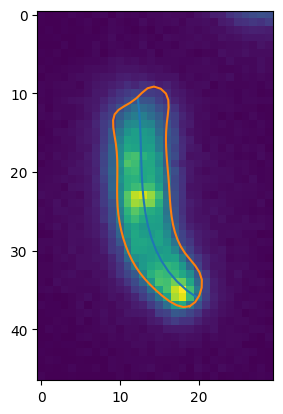

In [342]:
"""
def midline_extraction(mask,
                       outline,
                       orientation = None,
                       pixel_microns=0.11,
                       init_method = 'zhang',
                       min_branch_length=0.25,
                       enable_fast_fit = True):
""";
n=201
mask = part[n]['$mask']
plt.imshow(part[n]['C1'])
outline = mo.utils.spline_approximation(part[n]['$outline'],
                                        n=len(part[n]['$outline']),
                                        closed=True,
                                        smooth_factor=3)

skeleton_found = False
orientation = part[n]['orientation']
solidity = part[n]['solidity']

mask_x,mask_y = np.where(mask==1)
mask_coords = np.array([mask_x,mask_y]).T
centroid = np.round(np.array([mask_x.mean(),mask_y.mean()])).astype(int)
midlines = []

pixel_microns=0.11
min_branch_length=0.25
min_branch_length_pix = int(np.round(min_branch_length/pixel_microns))+1

if (centroid in mask_coords) and solidity>0.8:
    regionprop_obj = regionprops(mask*1)[0]
    if orientation is None:
        orientation = regionprop_obj.orientation
    interp_factor=2
    x0,y0 = centroid
    pole1,pole2 = 1,1
    dx,dy = np.cos(orientation),np.sin(orientation)
    init_centerline = np.array([np.linspace(x0,x0+dx,10),
                                np.linspace(y0,y0+dy,10)]).T
    
    extended_centerline = mo.utils.extend_skeleton(init_centerline, outline,interpolation_factor=1)
    l = int(min(mo.utils.measure_length(extended_centerline),
            int(0.5*len(outline))))
    extended_centerline = mo.utils.spline_approximation(extended_centerline,
                                                        n=l,
                                                        smooth_factor=1,
                                                        closed=False)
    
    smooth_skel, _converged = mo.utils.midline_approximation(extended_centerline[min_branch_length_pix:-min_branch_length_pix],
                                                             outline,
                                                             move_pole1=True,
                                                             move_pole2=True,
                                                             tolerance=0.15,
                                                             max_iteration=25,
                                                             anchor_length=5)
    if _converged:
        midline = mo.utils.extend_skeleton(smooth_skel, 
                                           outline,
                                          find_pole1=pole1,
                                          find_pole2=pole2,
                                          interpolation_factor=1)
        midline=mo.utils.spline_approximation(midline,n=int(mo.utils.measure_length(extended_centerline)),
                                              smooth_factor=1,closed=False)
    else:
        midline = extended_centerline
    midlines = [midline]
if len(midlines)==0:
    midline_coords = []
    skeleton_coords, skeleton = mo.utils.skeleton_analysis(mask,
                                                       pruning=True,
                                                       method='zhang',
                                                       min_branch_length=min_branch_length_pix)
    skeleton_coords = mo.utils.merge_branch_points(skeleton_coords,max_dist=2)
    for i in range(len(skeleton_coords)):
        pole1, pole2 = skeleton_coords[i][0]
        xcoords = skeleton_coords[i][1]
        ycoords = skeleton_coords[i][2]
        skel_coords = np.array([xcoords, ycoords]).T
        max_length = mo.utils.measure_length(skel_coords)
        if max_length<15:
            interp_factor=0.5
        elif max_length<30:
            interp_factor=1.2
        elif max_length<80:
            interp_factor=1.5
        elif max_length<90:
            interp_factor=2
        else:
            interp_factor=2.5
        
        if len(xcoords) < 15:
            skel_coords = np.array([np.linspace(xcoords[0],xcoords[-1],max(5,int(max_length/interp_factor))),
                                    np.linspace(ycoords[0],ycoords[-1],max(5,int(max_length/interp_factor)))]).T
            anchor_length=1
        else:
            anchor_length=2
        simp = mo.utils.simplify_polygon(skel_coords,
                                         tolerance=0.8,
                                         interp_distance=interp_factor)
        smooth_skel, _converged = mo.utils.midline_approximation(simp,
                                                        outline,
                                                        max_iteration=25,
                                                        tolerance=0.1,
                                                        move_pole1 = pole1,
                                                        move_pole2 = pole2,
                                                        anchor_length=anchor_length)
        if not _converged:
            smooth_skel = simp
        smooth_skel = mo.utils.extend_skeleton(smooth_skel, 
                                   outline,
                                   find_pole1=pole1,
                                   find_pole2=pole2,
                                   interpolation_factor=1)
        smooth_skel=mo.utils.spline_approximation(smooth_skel,
                                                  n=len(smooth_skel),     
                                                  smooth_factor=2,closed=False)
        #plt.plot(smooth_skel[:,1],smooth_skel[:,0])
        #plt.plot(simp[:,1],simp[:,0])
        
        #"""
        #mid_sec = mo.utils.simplify_polygon(smooth_skel[1:-1],tolerance=0.9,interp_distance=1)
        #smooth_skel[1:-1] = mo.utils.spline_approximation(mid_sec,n=len(smooth_skel)-2,
        #                                                    smooth_factor=1,closed=False)
        
        #
        #""";
        
        midline_coords.append([[pole1,pole2],smooth_skel[:,0],smooth_skel[:,1]])
    midline_coords = mo.utils.merge_branch_points(midline_coords,max_dist=2)
    midlines = [np.array([x[1],x[2]]).T for x in midline_coords]
#plt.imshow(mask)
for m in midlines:
    
    plt.plot(m[:,1],m[:,0])
plt.plot(outline[:,1],outline[:,0])

In [274]:
skeleton_coords

[[[1, 0],
  [11, 12, 13, 14, 15, 16, 17, 18.666666666666668],
  [18, 18, 17, 17, 17, 17, 17, 16.666666666666668]],
 [[1, 0],
  [19, 19, 19, 19, 18.666666666666668],
  [12, 13, 14, 15, 16.666666666666668]],
 [[1, 0],
  [24, 24, 24, 23, 22, 21, 20, 18.666666666666668],
  [23, 22, 21, 20, 19, 18, 18, 16.666666666666668]]]

In [ ]:
if not skeleton_found:
    min_branch_length_pix = int(np.round(min_branch_length/pixel_microns))
    skeleton_coords, skeleton = mo.utils.skeleton_analysis(mask,
                                                           method='zhang',
                                                           min_branch_length=min_branch_length_pix)
    skeleton_coords = mo.utils.merge_branch_points(skeleton_coords,max_dist=5)
    return skeleton

True

In [166]:
from timeit import default_timer

fig=plt.figure(figsize=(10,10))
n=12
mask = part[n]['$mask']
#outline = part[n]['$outline']
outline = mo.utils.spline_approximation(part[n]['$outline'],
                                        n=len(part[n]['$outline']),
                                        closed=True,
                                        smooth_factor=3)
orientation = part[n]['orientation']
centroid = part[n]['centroid']
        interp_factor=2
        x0,y0 = centroid
        dx,dy = np.cos(orientation),np.sin(orientation)
        init_centerline = np.array([np.linspace(x0,x0+dx,30),
                                    np.linspace(y0,y0+dy,30)]).T
        extended_centerline = extend_skeleton(init_centerline, contour)
        smooth_skel, _converged = midline_approximation(extended_centerline[1:-1],
                                                        contour,max_iteration=1)
        midline = extend_skeleton(smooth_skel, contour,
                                  find_pole1=True,
                                  find_pole2=True,
                                  interpolation_factor=1)

#outline = part[n]['$outline']
skeleton_coords, skeleton = mo.utils.skeleton_analysis(mask,
                                                       pruning=True,
                                                       method='zhang',
                                                       min_branch_length=3)

plt.imshow(part[n]['C1'],cmap='gist_gray')
plt.plot(outline[:,1],outline[:,0])
#plt.imshow(skeleton)
skeleton_coords = mo.utils.merge_branch_points(skeleton_coords,max_dist=3)

for i in range(len(skeleton_coords)):



    
    t0 = default_timer()
    pole1, pole2 = skeleton_coords[i][0]
    xcoords = skeleton_coords[i][1]
    ycoords = skeleton_coords[i][2]
    skel_coords = np.array([xcoords, ycoords]).T
    max_length = mo.utils.measure_length(skel_coords)


    
    if max_length<15:
        interp_factor=0.5
    elif max_length<30:
        interp_factor=1.2
    elif max_length<80:
        interp_factor=1.5
    elif max_length<90:
        interp_factor=2
    else:
        interp_factor=2.5
    
    if len(xcoords) < 10:
        skel_coords = np.array([np.linspace(xcoords[0],xcoords[-1],max(5,int(max_length/interp_factor))),
                                np.linspace(ycoords[0],ycoords[-1],max(5,int(max_length/interp_factor)))]).T
        anchor_length=1
    else:
        anchor_length=2
    simp = mo.utils.simplify_polygon(skel_coords,
                                     tolerance=0.9,
                                     interp_distance=interp_factor)
    #simp = mo.utils.spline_approximation(simp,closed=False,n=len(simp),smooth_factor=3)
    
    
    #smooth_skel = mo.utils.simplify_polygon(smooth_skel,tolerance=0.5,interp_distance=1)
    #smooth_skel = mo.utils.spline_approximation(smooth_skel,
    #                                            smooth_factor=1,closed=False)
    
    #"""
    smooth_skel = mo.utils.extend_skeleton(simp, 
                                   outline,
                                   find_pole1=pole1,
                                   find_pole2=pole2,
                                   interpolation_factor=interp_factor,
                                   subdivide_pole_segment=5)

    smooth_skel, _converged = mo.utils.midline_approximation(smooth_skel,
                                                    outline,
                                                    max_iteration=5,
                                                    tolerance=0.01,
                                                    move_pole1 = pole1,
                                                    move_pole2 = pole2,
                                                    anchor_length=anchor_length)
    smooth_skel=mo.utils.simplify_polygon(smooth_skel,tolerance=0.8,interp_distance=1)
    smooth_skel=mo.utils.spline_approximation(smooth_skel,n=len(smooth_skel),
                                                        smooth_factor=1,closed=False)
    smooth_skel = mo.utils.extend_skeleton(smooth_skel[pole1:len(smooth_skel)-pole2], 
                                   outline,
                                   find_pole1=pole1,
                                   find_pole2=pole2,
                                   interpolation_factor=interp_factor,subdivide_pole_segment=5)
    #plt.plot(smooth_skel[:,1],smooth_skel[:,0])
    #plt.plot(simp[:,1],simp[:,0])
    
    #"""
    #mid_sec = mo.utils.simplify_polygon(smooth_skel[1:-1],tolerance=0.9,interp_distance=1)
    #smooth_skel[1:-1] = mo.utils.spline_approximation(mid_sec,n=len(smooth_skel)-2,
    #                                                    smooth_factor=1,closed=False)
    
    #
    #""";
    
    plt.plot(smooth_skel[:,1],smooth_skel[:,0])
    #plt.plot(simp[:,1],simp[:,0])
plt.imshow(skeleton)


IndentationError: unexpected indent (778849560.py, line 13)

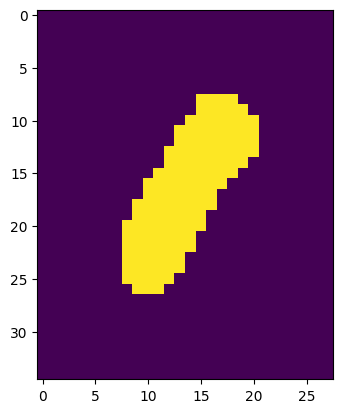

In [173]:
plt.imshow(mask)

## a,b=mo.utils.skeleton_analysis(mask,method='lee')

In [9]:
def merge_branch_points(skeleton_coords,max_dist=3):
    centroid_groups_id = []
    centroid_groups_x = []
    centroid_groups_y = []
    centroid_groups = []

    for p,x,y in skeleton_coords:
        if p[0]==0:
            centroid_groups_x.append(x[0])
            centroid_groups_y.append(y[0])
        if p[1]==0:
            centroid_groups_x.append(x[-1])
            centroid_groups_y.append(y[-1])
    centroid_groups_x=np.array(centroid_groups_x)
    centroid_groups_y=np.array(centroid_groups_y)
    new_coords = []
    for p,x,y in skeleton_coords:
        new_x = x.copy()
        new_y = y.copy()
        if p[0]==0:
            new_x[0]=centroid_groups_x[np.abs(centroid_groups_x-x[0])<max_dist].mean()
            new_y[0]=centroid_groups_y[np.abs(centroid_groups_y-y[0])<max_dist].mean()
        if p[1]==0:
            new_x[-1]=centroid_groups_x[np.abs(centroid_groups_x-x[-1])<max_dist].mean()
            new_y[-1]=centroid_groups_y[np.abs(centroid_groups_y-y[-1])<max_dist].mean()
        new_coords.append([p,new_x,new_y])
    return new_coords

def midline_approximation(skeleton, 
                          smoothed_contour,
                          move_pole1 = False,
                          move_pole2 = False, 
                          anchor_length = 3,
                          tolerance=0.1, max_iteration=10):
    """
    Approximation of a smooth midline with skeleton and a smoothed contour.

    :param skeleton: A numpy array of shape (n, 2) representing the skeleton of a 2D object.
    :param smoothed_contour: A numpy array of shape (m, 2) representing the smoothed contour of a 2D object.
    :param tolerance: A float representing the maximum distance between the midline and the skeleton at which convergence is achieved.
    :param max_iteration: An integer representing the maximum number of iterations to perform.
    :return: A tuple containing a numpy array of shape (p, 2) representing the midline approximation and a boolean indicating whether convergence was achieved.
    """
    midline = skeleton.copy()
    pole1_anchor = []
    pole2_anchor = []
    
    if not move_pole1:
        pole1_anchor = midline[:anchor_length]
        midline = midline[anchor_length:]
    if not move_pole2:
        pole2_anchor = midline[-anchor_length:]
        midline = midline[:-anchor_length]
    
    n = 0
    converged = False
    while n < max_iteration:
        updated_midline = mo.utils.midline.skeleton_contour_intersect_points(midline, smoothed_contour)
        dxy = updated_midline - midline
        updated_midline = mo.utils.linalg.spline_approximation(updated_midline, 
                                                   n=len(updated_midline),
                                                   smooth_factor=1, closed=False)
        if np.abs(dxy).mean() <= tolerance:
            converged = True
            break
        n += 1
    stiched_midline = []
    if not move_pole1:
        stiched_midline.append(pole1_anchor)
    stiched_midline.append(updated_midline)
    if not move_pole2:
        stiched_midline.append(pole2_anchor)
    midline = np.vstack(stiched_midline)
    return midline.astype(float), converged


def extend_skeleton(smoothed_skeleton,
                    smoothed_contour,
                    find_pole1=True,
                    find_pole2=True,
                    subdivide_pole_segment=5,
                    interpolation_factor=1):
    # initiate approximated tip points
    new_pole1, new_pole2, smoothed_skeleton = mo.utils.find_poles(smoothed_skeleton,
                                                                 smoothed_contour,
                                                                 find_pole1=find_pole1,
                                                                 find_pole2=find_pole2)

    extended_skeleton = []
    if find_pole1:
        segment1 = (np.array([np.linspace(new_pole1[0][0], smoothed_skeleton[0, 0], subdivide_pole_segment),
                              np.linspace(new_pole1[0][1], smoothed_skeleton[0, 1], subdivide_pole_segment)]).T)[:-1]
    else:
        segment1 = new_pole1
    if find_pole2:
        segment2 = (np.array([np.linspace(smoothed_skeleton[-1, 0], new_pole2[0][0], subdivide_pole_segment),
                              np.linspace(smoothed_skeleton[-1, 1], new_pole2[0][1], subdivide_pole_segment)]).T)[1:]
    else:
        segment2 = new_pole2

    extended_skeleton = np.concatenate([segment1,
                                        smoothed_skeleton,
                                        segment2])
    return mo.utils.spline_approximation(extended_skeleton,
                                        n=int(interpolation_factor * len(smoothed_skeleton)),
                                        smooth_factor=0, closed=False)

In [473]:
centroid_groups_x

[33, 32, 34]

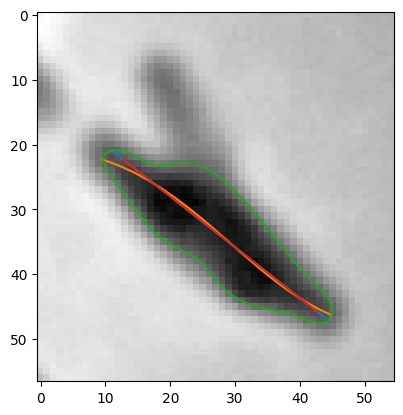

<Figure size 640x480 with 0 Axes>

In [11]:
regionprop_obj = regionprops(mask*1)[0]
orientation = regionprop_obj.orientation
max_length = regionprop_obj.major_axis_length
centroid = regionprop_obj.centroid
if max_length<15:
    interp_factor=0.5
elif max_length<30:
    interp_factor=1.5
elif max_length<80:
    interp_factor=2
elif max_length<90:
    interp_factor=2.5
else:
    interp_factor=3
x0,y0 = centroid
dx,dy = np.cos(orientation),np.sin(orientation)
init_centerline = np.array([np.linspace(x0,x0+dx,int(max_length/interp_factor)),
                            np.linspace(y0,y0+dy,int(max_length/interp_factor))]).T
extended_centerline = mo.utils.extend_skeleton(init_centerline, outline)
smooth_skel, _converged = midline_approximation(extended_centerline[1:-1],
                                                outline,max_iteration=30,
                                                move_pole1 = True,
                                                move_pole2 = True,
                                                tolerance=0.01,anchor_length=3)
smooth_skel = mo.utils.extend_skeleton(smooth_skel, outline)
plt.imshow(part[n]['Phase_Ian'],cmap='gist_gray')
plt.plot(extended_centerline[:,1],extended_centerline[:,0])
plt.plot(smooth_skel[:,1],smooth_skel[:,0])
plt.plot(outline[:,1],outline[:,0])
plt.plot(extended_centerline[1:-1,1],extended_centerline[1:-1,0])
fig2=plt.figure()

In [42]:
regionprop_obj = measure.regionprops(mask*1)[0]
        if orientation is None:
            orientation = regionprop_obj.orientation
        if centroid is None:
            centroid = regionprop_obj.centroid
        interp_factor=2
        x0,y0 = centroid
        dx,dy = np.cos(orientation),np.sin(orientation)
        init_centerline = np.array([np.linspace(x0,x0+dx,30),
                                    np.linspace(y0,y0+dy,30)]).T
        extended_centerline = extend_skeleton(init_centerline, contour)
        smooth_skel, _converged = midline_approximation(extended_centerline[1:-1],
                                                        contour,max_iteration=1,)
        midline = extend_skeleton(smooth_skel, contour,
                                  find_pole1=True,
                                  find_pole2=True,
                                  interpolation_factor=1)

IndentationError: unexpected indent (203034708.py, line 2)

In [12]:
def mask2midline(mask,
                 contour,
                 ellipse_fast=False,
                 orientation=None,
                 centroid=None,
                 pruning=True, 
                 min_branch_length=5,
                 max_iteration=2):

    warnings.filterwarnings("ignore")
    """

    :param mask: binary mask
    :param contour: contour polygon
    :param ellipse_fast: fit to ellipse then use the line connecting the two distal poles to initialize midline
    :param orientation: precomputed orientation of the particle
    :param centroid: precomputed centroid of the particle
    :param pruning: prune branches if set to True
    :param min_branch_length: maximum length of branches to be pruned
    :param max_iteration: maximum number of iterations
    :return: midline as numpy.array with a shape of N x 2
    """
    
    if not ellipse_fast:
        skeleton_coords, skeleton = skeleton_analysis(mask,pruning=pruning,
                                                      min_branch_length=min_branch_length)
        pole1, pole2 = skeleton_coords[0][0]
        xcoords = skeleton_coords[0][1]
        ycoords = skeleton_coords[0][2]
        skel_coords = np.array([xcoords, ycoords]).T
        if len(skel_coords)<20:
            interp_factor=1
        else:
            interp_factor=2
        smooth_skel = spline_approximation(skel_coords,
                                           n=int(len(skel_coords)/interp_factor),
                                           smooth_factor=3, closed=False)
        smooth_skel, _converged = midline_approximation(smooth_skel,
                                                        contour,max_iteration=max_iteration)
        midline = extend_skeleton(smooth_skel, contour,
                                           find_pole1=pole1,
                                           find_pole2=pole2,
                                           interpolation_factor=interp_factor)
    else:
        regionprop_obj = measure.regionprops(mask*1)[0]
        if orientation is None:
            orientation = regionprop_obj.orientation
        if centroid is None:
            centroid = regionprop_obj.centroid
        interp_factor=2
        x0,y0 = centroid
        dx,dy = np.cos(orientation),np.sin(orientation)
        init_centerline = np.array([np.linspace(x0,x0+dx,30),
                                    np.linspace(y0,y0+dy,30)]).T
        extended_centerline = extend_skeleton(init_centerline, contour)
        smooth_skel, _converged = midline_approximation(extended_centerline[1:-1],
                                                        contour,max_iteration=1)
        midline = extend_skeleton(smooth_skel, contour,
                                  find_pole1=True,
                                  find_pole2=True,
                                  interpolation_factor=1)

    return midline

In [53]:
p.get_particle_data(p.regionprops[p.regionprops['$include']>0].index[34])['Phase_Ian'].max()

0.5995380682519865

In [12]:
p.regionprops.columns

Index(['$bbox-0', '$bbox-1', '$bbox-2', '$bbox-3', '$coords', '$centroid-0',
       '$centroid-1', 'area', 'convex_area', 'filled_area', 'eccentricity',
       'solidity', 'major_axis_length', 'minor_axis_length', 'perimeter',
       'equivalent_diameter', 'extent', 'orientation', 'inertia_tensor-0-0',
       'inertia_tensor-0-1', 'inertia_tensor-1-0', 'inertia_tensor-1-1',
       'moments_hu-0', 'moments_hu-1', 'moments_hu-2', 'moments_hu-3',
       'moments_hu-4', 'moments_hu-5', 'moments_hu-6', 'weighted_moments_hu-0',
       'weighted_moments_hu-1', 'weighted_moments_hu-2',
       'weighted_moments_hu-3', 'weighted_moments_hu-4',
       'weighted_moments_hu-5', 'weighted_moments_hu-6', 'mean_intensity',
       'max_intensity', 'min_intensity', 'compactness', 'rough_length',
       'aspect_ratio', '$image_id', '$opt-x1', '$opt-y1', '$opt-x2', '$opt-y2',
       '$touching_edge', '$include', '$midlines', '$outline',
       '$refined_outline', 'min_negative_curvature', 'max_positive_cu

In [11]:
from skimage import measure,morphology,transform,draw

In [12]:
draw.polygon2mask

<function skimage.draw._polygon2mask.polygon2mask(image_shape, polygon)>

In [97]:
p.annotate_particles()

AttributeError: module 'PIL.ImageQt' has no attribute 'ImageQt'

In [98]:
import PIL

In [99]:
PIL.ImageQt.

Help on module PIL.ImageQt in PIL:

NAME
    PIL.ImageQt

DESCRIPTION
    # The Python Imaging Library.
    # $Id$
    #
    # a simple Qt image interface.
    #
    # history:
    # 2006-06-03 fl: created
    # 2006-06-04 fl: inherit from QImage instead of wrapping it
    # 2006-06-05 fl: removed toimage helper; move string support to ImageQt
    # 2013-11-13 fl: add support for Qt5 (aurelien.ballier@cyclonit.com)
    #
    # Copyright (c) 2006 by Secret Labs AB
    # Copyright (c) 2006 by Fredrik Lundh
    #
    # See the README file for information on usage and redistribution.
    #

FUNCTIONS
    align8to32(bytes, width, mode)
        converts each scanline of data from 8 bit to 32 bit aligned
    
    fromqimage(im)
        :param im: QImage or PIL ImageQt object
    
    fromqpixmap(im)
    
    rgb(r, g, b, a=255)
        (Internal) Turns an RGB color into a Qt compatible color integer.
    
    toqimage(im)
    
    toqpixmap(im)

DATA
    qt_is_installed = False
    qt_module 